<a href="https://colab.research.google.com/github/Jownao/tweets-sentiment-analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TCC**



> Explorando a polaridade através da análise de tweets: Um estudo sobre a Revolta de 8 de janeiro de 2023






### Imports e bibliotecas


In [1]:
# Instalação do PySpark e Spark-nlp
!pip install pyspark
!pip install spark-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=566fd89f9683ff552d8ba946eb32d31e411ccec213aa492b40198cabfdaf5247
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.7/486.7 kB 36.0 MB/s eta 0:00:00


In [2]:
### Imports Necessários

## Imports do Python
from collections import Counter
import nltk
import pandas as pd 
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import string
import re
import regex
import unicodedata

## Imports do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score,cohen_kappa_score,roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Imports do PySpark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA

## Imports do spark-nlp
import sparknlp
from sparknlp.annotator import Chunker, PerceptronModel, LemmatizerModel, Stemmer, Tokenizer, StopWordsCleaner, Normalizer, YakeKeywordExtraction, SentenceDetector, NGramGenerator, BertEmbeddings
from sparknlp.annotator import NerDLModel, BertForTokenClassification, NerConverter, SentenceDetectorDLModel
from sparknlp.annotator import (Tokenizer, Normalizer, LemmatizerModel, StopWordsCleaner)
from sparknlp.base import DocumentAssembler, Finisher, LightPipeline
from sparknlp.pretrained import PretrainedPipeline


## Imports do nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer




In [3]:
# Funções

# Retorna somente as menções daquele tweet dentro da coluna 'entities'
def get_mentions(dicionario):
    if isinstance(dicionario, dict):
        return [m['username'] for m in dicionario.get('mentions', [])]
    else:
        return []
# Pega o nome de usuário do autor do tweet dentro da coluna 'author'
def get_username(dicionario):

    return dicionario['username']
# Pega o id do autor do tweet dentro da coluna 'author'
def get_id(dicionario):
    return dicionario['id']

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Diretórios
* diretorio_corp = ("/content/drive/MyDrive/dataset/")
* diretorio_unit = ('/content/drive/MyDrive/dataset_tcc/')

## Pré-processamento

### Pré-processamento (colunas)

In [5]:
diretorio = ("/content/drive/MyDrive/dataset/") ## Corporativo

In [6]:
# diretorio = ('/content/drive/MyDrive/dataset_tcc/') ## Unit

In [7]:
# Ler a base
data = pd.read_json(diretorio+'random500/random500.json') 

In [8]:
# Função criada para filtrar as colunas e adicionar outras

def pretext_col(data):
  # Deixar somente tweets do brasil (pt)
  data = data[data['lang'].str.contains('pt')]

  # Filtra os tweets que não contém o aviso de conta no campo text
  data = data[~data["text"].str.contains("account has been withheld")]

  # Tira os tweets duplicados para não enviesar a análise
  data.drop_duplicates(subset=['text'], inplace=True)

  # Criar coluna com nome de usuário e ID do usuário
  data['user'] = data['author'].apply(get_username)
  data['user_id'] = data['author'].apply(get_id)

  # Sem retweets
  data_semrt = data[~data['text'].str.contains('RT @')]
  # Redefinindo o índice
  data_semrt = data_semrt.reset_index(drop=True)
  
  return data,data_semrt


In [9]:
data, data_semrt = pretext_col(data)

In [10]:
data.shape

(11915, 22)

In [11]:
data_semrt.shape

(6359, 22)

### Pré-processamento (texto)

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


def clean_text(texto):

    def remove_tweet_ruido(tweets_text):

          clean_text = re.sub(r'^rt\s+', '', tweets_text) 
          clean_text = re.sub(r'@\S+', '', clean_text)  
          clean_text = re.sub(r'http\S+', '', clean_text) 
          clean_text = clean_text.replace("\n", " ")

          return clean_text

    # Transforme as letras para minúscula
    texto = texto.lower()
    
    # Remova o ruido do texto
    texto = remove_tweet_ruido(texto)
    
    # Tokenize o texto em palavras
    palavras = word_tokenize(texto)
    
    # Remova pontuações
    palavras_sem_pontuacao = [palavra for palavra in palavras if palavra not in string.punctuation]
    
    # Remova stopwords
    stops = set(stopwords.words('portuguese'))
    palavras_sem_stopwords = [palavra for palavra in palavras_sem_pontuacao if palavra not in stops]
    
    # Lematize o texto
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(palavra, pos='v') if pos.startswith('V') else lemmatizer.lemmatize(palavra) for palavra, pos in nltk.pos_tag(palavras_sem_stopwords)]
    
    # Junte as palavras limpas
    texto_limpo = ' '.join(lemmas)
    
    # Remova acentos
    texto_limpo = unicodedata.normalize('NFKD', texto_limpo).encode('ASCII', 'ignore').decode('ASCII')
    
    return texto_limpo


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# import re
# import spacy
# import unicodedata

# # Carregue o modelo em português
# nlp = spacy.load("pt_core_news_sm")

# def clean_text_spacy(texto):
#     def remove_tweet_ruido(tweets_text):
#         clean_text = re.sub(r'^rt\s+', '', tweets_text)
#         clean_text = re.sub(r'@\S+', '', clean_text)
#         clean_text = re.sub(r'http\S+', '', clean_text)
#         clean_text = clean_text.replace("\n", " ")

#         return clean_text

#     # Transforme as letras para minúscula
#     texto = texto.lower()

#     # Remova o ruido do texto
#     texto = remove_tweet_ruido(texto)

#     # Processe o texto com spaCy
#     doc = nlp(texto)

#     # Remova pontuações e stopwords, e lematize o texto
#     tokens = [
#         token.lemma_ for token in doc if not (token.is_punct or token.is_stop)
#     ]

#     # Junte as palavras limpas
#     texto_limpo = " ".join(tokens)

#     # Remova acentos
#     texto_limpo = unicodedata.normalize("NFKD", texto_limpo).encode("ASCII", "ignore").decode("ASCII")

#     return texto_limpo


In [ ]:
# data = pd.read_csv(diretorio + 'random500/tweets_500.csv')

In [ ]:
# Aplica o processamento de texto na coluna text e cria uma nova "clean_text"
data['clean_text'] = data['text'].apply(clean_text)

# Remove tweets com menos de 2 palavras e tweets que ficaram vazios
data['num_palavras'] = data['clean_text'].apply(lambda x: len(x.split()))
data = data.loc[data['num_palavras'] > 1]
data = data.dropna(axis=1, how='all')

In [ ]:
# Aplica o processamento de texto na coluna text e cria uma nova "clean_text"
data_semrt['clean_text'] = data_semrt['text'].apply(clean_text)

# Remove tweets com menos de 2 palavras e tweets que ficaram vazios
data_semrt['num_palavras'] = data_semrt['clean_text'].apply(lambda x: len(x.split()))
data_semrt = data_semrt.loc[data_semrt['num_palavras'] > 1]
data_semrt = data_semrt.dropna(axis=1, how='all')

In [ ]:
data.shape

(11836, 23)

In [ ]:
data_semrt.shape

(6304, 23)

### Análise da base

In [ ]:
# Diferença do total de tweets originais e retweets
num_linhas = data.shape[0]
num_linhas_semrt = data_semrt.shape[0]
num_linhas_rt = num_linhas-num_linhas_semrt
# Imprime o número de linhas
print("Número de linhas do dataframe:", num_linhas)
print("Número de linhas do dataframe sem RT:", num_linhas_semrt)

print(f'De {num_linhas} , {num_linhas_rt} são retweets.')

Número de linhas do dataframe: 11836
Número de linhas do dataframe sem RT: 6304
De 11836 , 5532 são retweets.


### Criar base de tweets

In [ ]:
# # Tweets sem pré-processamento
# data_tweets_rt = data.loc[:, ['created_at', 'author_id', 'user', 'id', 'text']]
# data_tweets = data_semrt.loc[:, ['created_at', 'author_id', 'user', 'id', 'text']]

In [ ]:
# Tweets com pré-processamento
data_tweets_rt = data.loc[:, ['user', 'id', 'text','clean_text']]
data_tweets = data_semrt.loc[:, ['user', 'id', 'text','clean_text']]

In [ ]:
data_tweets_rt.shape

(11836, 4)

In [ ]:
data_tweets.shape

(6304, 4)

In [ ]:
print('Quantidade de usuários únicos:',len(data_tweets_rt['id'].unique()))

Quantidade de usuários únicos: 11828


In [ ]:
print('Quantidade de usuários únicos:',len(data_tweets['id'].unique()))

Quantidade de usuários únicos: 6302


In [ ]:
# salvando o DataFrame em um arquivo CSV
data_tweets_rt.to_csv('tweets_rt500.csv', index=False)
data_tweets.to_csv('tweets_500.csv', index=False)

# # salvando o DataFrame em um arquivo JSON
# data_tweets.to_json('tweets500.json')
# data_semrt.to_json('tweets_srt500.json')

In [ ]:
# # lendo o arquivo JSON salvo para verificar se foi salvo corretamente
# df_lido = pd.read_json('tweets_rt500.json')
# df_lido.head()

In [ ]:
# # lendo o arquivo CSV salvo para verificar se foi salvo corretamente
# df_lido = pd.read_csv('tweets_500.csv')
# df_lido.head()

### Criar base de usuários únicos

In [ ]:
# Pega os usuários únicos
data_usuarios = data[['user', 'id']].drop_duplicates().groupby('id')['user'].apply(list).reset_index()

In [ ]:
data_usuarios.head()

,id,user
0,1612074023868850176,[Biliwnews]
1,1612074030353227776,[__fatimasouza]
2,1612074031993208832,[ElianaSimes3]
3,1612074043548782592,[BorgesEdnair]
4,1612074044479754240,[hygino_david]


In [ ]:
data_usuarios.count()

id      11828
user    11828
dtype: int64

In [ ]:
#data_usuarios[['id']].to_csv('ids.csv', index=False)


In [ ]:
#data_usuarios[['id','user']].to_csv('ids_user.csv', index=False)

### Criar base de usuários e interações

* Na matriz de interação, somente os usuários que foram mencionados em alguma postagem e que também mencionaram outros usuários são considerados. Se um usuário não mencionou ninguém e não foi mencionado, ele não estará presente na matriz. E se um usuário mencionou outros usuários, mas esses outros usuários não mencionaram ele de volta, então a interação entre eles será contabilizada como zero. Por isso, é possível que existam muitos usuários na base, mas que somente alguns tenham interações entre si.

In [ ]:
import pandas as pd
import re

# carrega o dataframe com as postagens
df = data_semrt

# extrai as menções de cada postagem
mentions = df['text'].apply(lambda x: re.findall(r'@\w+', x))

# cria uma lista com todos os usuários mencionados
users = set([user for mention_list in mentions for user in mention_list])




In [ ]:

# cria uma matriz de interações
interaction_matrix = pd.DataFrame(0, index=list(users), columns=list(users))

# preenche a matriz de interações
for mention_list in mentions:
    for i in range(len(mention_list)):
        for j in range(i+1, len(mention_list)):
            user1 = mention_list[i]
            user2 = mention_list[j]
            interaction_matrix.loc[user1, user2] += 1
            interaction_matrix.loc[user2, user1] += 1
# cria o dataframe de interações
df_interactions = pd.DataFrame(interaction_matrix)

In [ ]:
# Aqui ainda possui usuários que mencionaram mas não foram mencionados devolta

df_interactions.head(5080)


,@rodmanoel1944,@JuFinamore,@BrunoTricolorSP,@gaiofact,@surdo_kibe,@CanaldoNegaoo,@josianezwirtes,@DinoDebochado,@joaopiresrj,@RachelSherazade,...,@CapitalismoCult,@RdGuaibaOficial,@exercitooficial,@ROMMALU,@AnaMariadaGraa2,@taoquei1,@CARLOSR86493600,@bastidoresport,@valoreconomico,@abcnews
@rodmanoel1944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@JuFinamore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@BrunoTricolorSP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@gaiofact,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@surdo_kibe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
@taoquei1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@CARLOSR86493600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@bastidoresport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@valoreconomico,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Salvar arquivo
# df_interactions.to_csv('interactions.csv', index=False)

In [ ]:
# seleciona as linhas e colunas com interações
df_interactions = df_interactions.loc[:, df_interactions.any()]

# remove as linhas e colunas sem interações
df_interactions = df_interactions.loc[df_interactions.any(axis=1), :]



In [ ]:
df_interactions.head(5000)

,@rodmanoel1944,@JuFinamore,@BrunoTricolorSP,@gaiofact,@surdo_kibe,@josianezwirtes,@joaopiresrj,@RachelSherazade,@Walterwawal,@tvglobo,...,@JOSDANIELROCHA3,@Bh2Mrcio,@Metropoles,@CapitalismoCult,@RdGuaibaOficial,@exercitooficial,@ROMMALU,@AnaMariadaGraa2,@taoquei1,@abcnews
@rodmanoel1944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@JuFinamore,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@BrunoTricolorSP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@gaiofact,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@surdo_kibe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
@exercitooficial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,0,0,12
@ROMMALU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@AnaMariadaGraa2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
@taoquei1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_interactions.to_csv('grafo.csv')

In [ ]:
# selecione apenas as linhas em que o usuário é 'x'
usuario = df_interactions.loc['@77_frota', :]

# filtra as colunas que têm valores diferentes de zero
usuario = usuario[usuario != 0]

# exibe as interações do usuário "@guilhermealt"
usuario.head()

@clubdodom          1
@_Janoninho         1
@andersongtorres    2
@exercitooficial    4
@CFOAB              1
Name: @77_frota, dtype: int64

### Nuvem de palavras (pronto)

#### Testes

In [ ]:
# palavra_especifica = 'splash'
# frequencia = tweets['clean_text'].str.contains(palavra_especifica).sum()
# print(f'A palavra "{palavra_especifica}" aparece {frequencia} vezes nos textos.')


A palavra "splash" aparece 1 vezes nos textos.


In [ ]:
# from collections import Counter

# # Juntar todos os textos em uma única string
# all_text = ' '.join(tweets['clean_text'])

# # Dividir a string em palavras e contar a frequência
# word_freq = Counter(all_text.split())

# # Imprimir as 10 palavras mais frequentes
# for word, freq in word_freq.most_common(30):
#     print(f'{word}: {freq}')

brasilia: 4144
congresso: 3061
stf: 1974
invadir: 1515
terroristas: 1317
nacional: 1191
planalto: 1177
pra: 1022
brasiliar: 1021
bolsonaristas: 930
acontecer: 694
ta: 659
policia: 643
invasao: 641
lula: 641
palacio: 622
brasil: 548
brasilio: 546
manifestantes: 538
df: 510
golpistas: 509
tomar: 498
federal: 484
bolsonaro: 471
presidente: 420
fazer: 416
prender: 409
atos: 403
seguranca: 396
gente: 376


#### -

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# tweets = data

tweets = pd.read_csv(diretorio + 'random500/tweets_500.csv')

In [ ]:
tweets.head()

,user,id,text,clean_text
0,fefeliperb,1612236350392082432,@gxbr1el_ @BonnerMVP_ KKKKKKKKKKKKKK Os splash...,kkkkkkkkkkkkkk splash brothers dominar brasilia
1,markinhos88,1612236350249656320,Estava na cara que iriam fazer isso é deixaram...,cara iriam deixar pior invadir brasilia polici...
2,allah_andy,1612236349251244032,Maneiro que TODOS os jornalistas da Globo estã...,maneiro jornalistas globo tratar golpistas idi...
3,DeaASCESOL,1612236349125402624,"Esquerdistas vândalos, infiltrados. @JovemPanN...",esquerdistas vandalos infiltrar brasilia brazi...
4,hhugogarciaa,1612236348848480256,que loucura esse momento em brasília,loucura brasilia


In [ ]:
stopwords = set()
# adicionando palavras-chave e palavras indesejadas como stopwords
stopwords.update(["brasília", "stf","congresso","clean_text","brasilia","Length","kkkkkkkkkkkkkk","Name","dtype","object","splash","brothers","pub","ur","cu","q","ca","ta","idi","iriam","brazi"]) 


wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=40, 
    scale=3,
    random_state=2
).generate(str(tweets['clean_text']))



In [ ]:
# teste = tweets[tweets["clean_text"].str.contains("idi ")]
# teste.head()

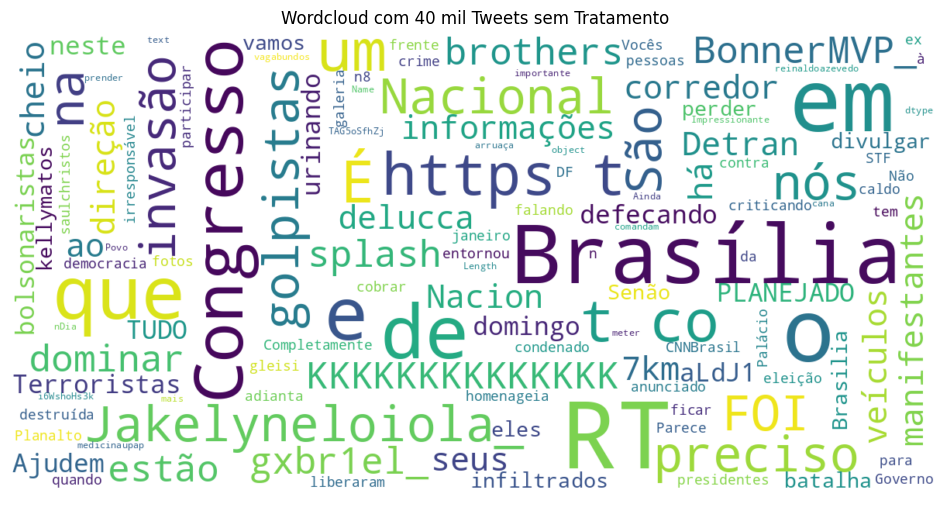

In [ ]:
# Wordcloud sem tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud com 40 mil Tweets sem Tratamento")
plt.show()


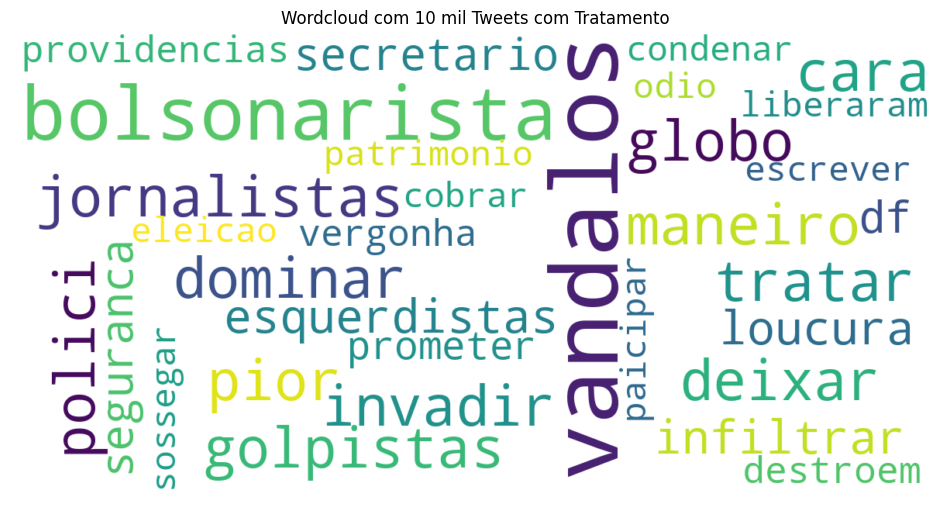

In [ ]:
# Wordcloud com tratamento
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud com 10 mil Tweets com Tratamento")
plt.show()


### Grafo (pronto)

In [ ]:
import networkx as nx
import pandas as pd

df_tweets = data_semrt

In [ ]:
# Pega todas menções
df_tweets['users_mention'] = df_tweets['entities'].apply(get_mentions)

# Criar dataframe com todos nome de usuários únicos
data_usuarios = pd.DataFrame(df_tweets['user'].unique() , columns=['user'])

* Visualização dos usuários mais mencionados

In [ ]:
# Concatenando os nomes dos usuários separados por vírgulas
df_tweets['usuarios_mencionados_str'] = df_tweets['users_mention'].apply(lambda x: ', '.join(x))

# Seleciona os top 10 valores
top10 = df_tweets['usuarios_mencionados_str'].value_counts().head(11)

# Transforma em um dicionário
top_10_dict = dict(top10)

# Criando o DataFrame a partir do dicionário e da lista de índices
df = pd.DataFrame(list(top_10_dict.items()), index=[i for i in range(0,11)], columns=['usuarios', 'mencoes'])

# Excluindo a primeira linha que são os NULL
df = df.drop(df.index[0])

# Imprimindo o DataFrame
df

,usuarios,mencoes
1,STF_oficial,76
2,YouTube,59
3,FlavioDino,57
4,ArthurLira_,56
5,LulaOficial,52
6,SF_Moro,47
7,choquei,43
8,IbaneisOficial,39
9,AndreJanonesAdv,35
10,"GeorgMarques, STF_oficial",34


In [ ]:
# Cria o grafo vazio
grafo = nx.Graph()

# Adiciona nós (usuários) ao grafo
grafo.add_nodes_from(data_usuarios)

usuarios = data_usuarios['user'].tolist() # Usuarios do tweet

usuarios_mencionados = set()
for index, row in df_tweets.iterrows():
    texto_tweet = row['text']
    usuario_tweet = row['user']
    mencoes = [palavra for palavra in texto_tweet.split() if palavra.startswith('@')]

    for mencao in mencoes:
        usuario_mencionado = mencao.replace('@', '')
        if usuario_mencionado in usuarios:
            usuarios_mencionados.add(usuario_mencionado)
            grafo.add_edge(usuario_tweet, usuario_mencionado)

grafo.add_nodes_from(list(usuarios_mencionados)[:10])


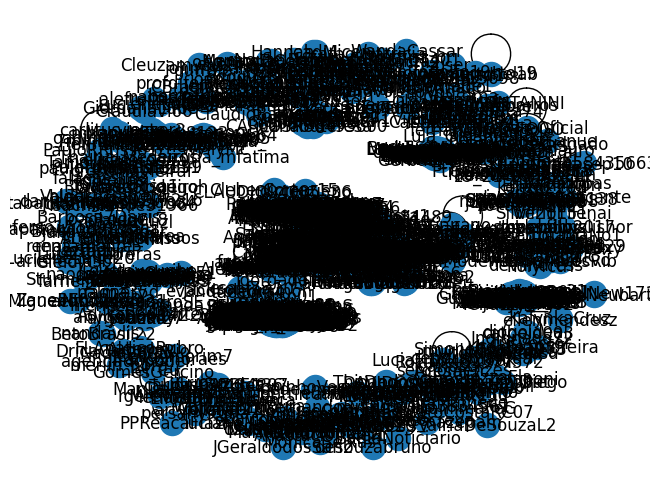

In [ ]:
import matplotlib.pyplot as plt

nx.draw(grafo, with_labels=True)
plt.show()


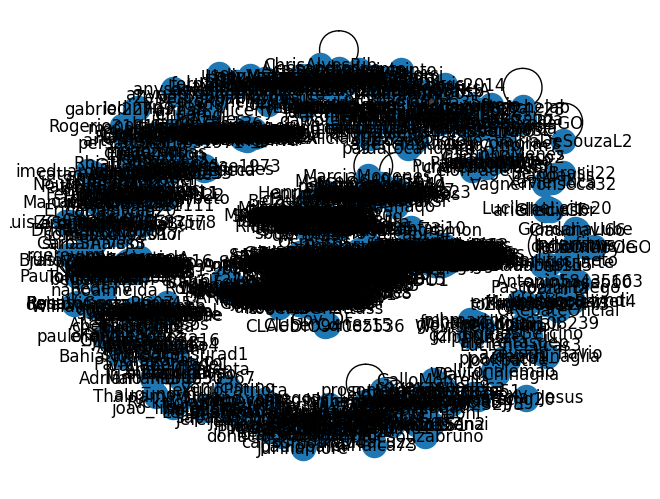

In [ ]:
import matplotlib.pyplot as plt

nx.draw(grafo, with_labels=True)
plt.show()


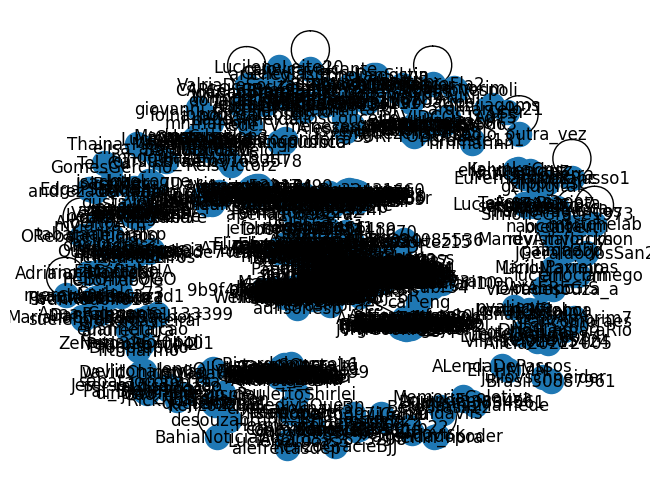

In [ ]:
import matplotlib.pyplot as plt

nx.draw(grafo, with_labels=True)
plt.show()


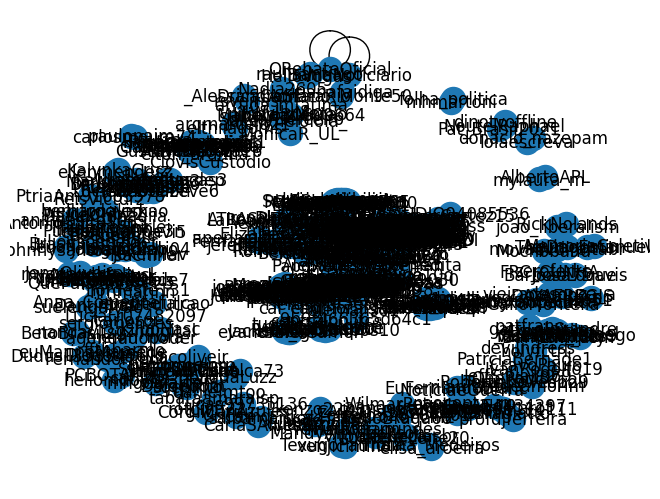

In [ ]:
import matplotlib.pyplot as plt

nx.draw(grafo, with_labels=True)
plt.show()


In [ ]:
# Adiciona nós (usuários) ao grafo
grafo.add_nodes_from(data_usuarios)

usuarios = df_tweets['user'].tolist() # Usuarios do tweet

for index, row in df_tweets.iterrows():
    texto_tweet = row['text']
    usuario_tweet = row['user']
    mencoes = [palavra for palavra in texto_tweet.split() if palavra.startswith('@')]
    
    for mencao in mencoes:
        usuario_mencionado = mencao.replace('@', '')
        if usuario_mencionado in usuarios:
            grafo.add_edge(usuario_tweet, usuario_mencionado)

# Calcula centralidade de grau de cada nó
centralidade_grau = nx.degree_centrality(grafo)

# Seleciona os 10 nós com maior centralidade de grau
nos_centrais = sorted(centralidade_grau, key=centralidade_grau.get, reverse=True)[:20]

# Cria subgrafo com os 10 nós mais centrais
subgrafo = grafo.subgraph(nos_centrais)

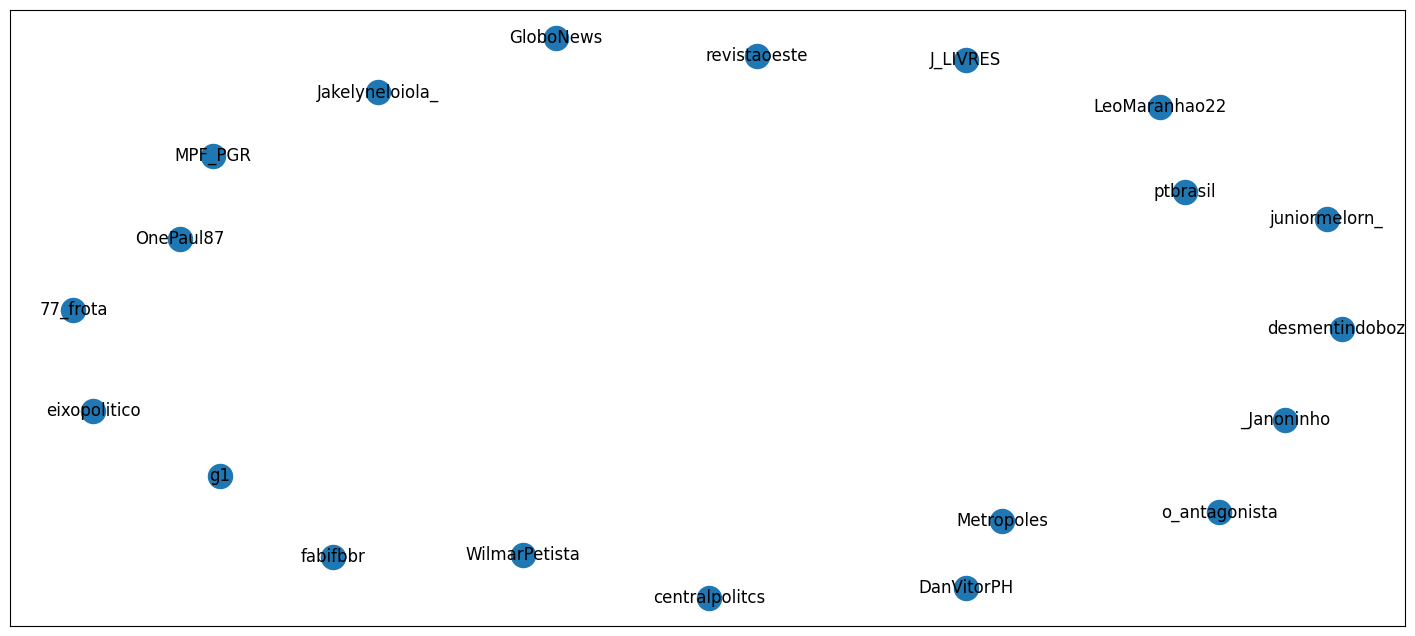

In [ ]:
# Desenha o subgrafo com as labels dos nós
fig, ax = plt.subplots(figsize=(18, 8))

pos = nx.spring_layout(subgrafo)
nx.draw_networkx(subgrafo, pos=pos, with_labels=True)


# Mostra o grafo
plt.show()

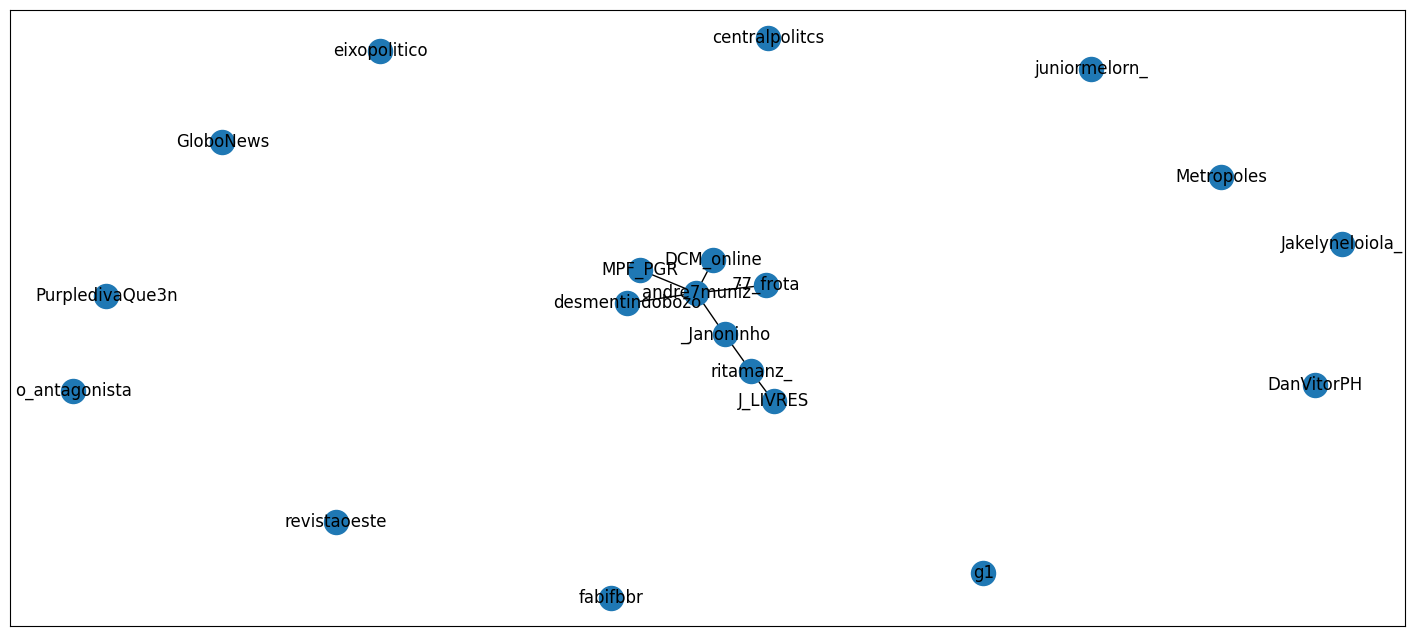

In [ ]:
# Desenha o subgrafo com as labels dos nós
fig, ax = plt.subplots(figsize=(18, 8))

pos = nx.spring_layout(subgrafo)
nx.draw_networkx(subgrafo, pos=pos, with_labels=True)


# Mostra o grafo
plt.show()

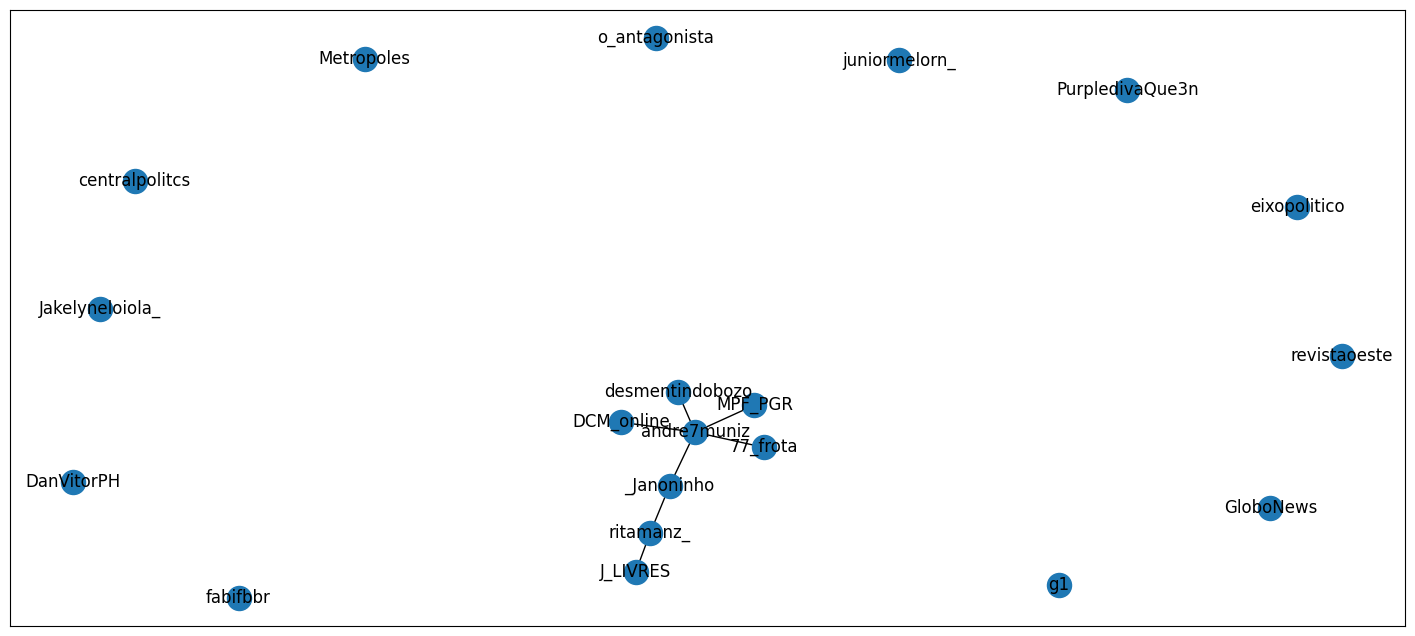

In [ ]:
# Desenha o subgrafo com as labels dos nós
fig, ax = plt.subplots(figsize=(18, 8))

pos = nx.spring_layout(subgrafo)
nx.draw_networkx(subgrafo, pos=pos, with_labels=True)


# Mostra o grafo
plt.show()

### Amostra

In [ ]:
# import pandas as pd
tweets = pd.read_csv(diretorio + 'random500/tweets_500.csv')
# leitura do arquivo CSV
df = tweets

# seleção de 3000 tweets aleatórios
df_aleatorio = df.sample(n=3000, random_state=24)

# salvando em um novo arquivo XLSX
df_aleatorio.to_excel('tweets_aleatorios.xlsx', index=False)


# Modelagem dos modelos

## Scikit learn

In [95]:
# Import
# df_final_dataset = pd.read_excel(diretorio+"teste803.xlsx")
df_final_dataset = pd.read_csv(diretorio+"teste62_75_61.csv")
# df_final_dataset = results_df


# Primeiro teste
df_final_dataset['sentiment'].value_counts()




# Cria as listas para armazenar os textos e rótulos
tweets = []
rotulos = []

# Loop pelas instâncias do conjunto de dados
for index, row in df_final_dataset.iterrows():
    # Adiciona o texto e rótulo das instâncias às listas correspondentes
    tweets.append(row['clean_text'])
    rotulos.append(row['sentiment'])

df_final_dataset['sentiment'].value_counts()

-1    300
 0    300
 1    202
Name: sentiment, dtype: int64

In [96]:
vetorizado = TfidfVectorizer(use_idf=True)
X = vetorizado.fit_transform(tweets)
Y = rotulos

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state=42,
                                                    test_size=0.2
                                                   )

print('Número de linhas no conjunto total: {}'.format(len(tweets)))
print('Número de linhas no conjunto de treinamento: {} ({:.2%} do total)'.format(X_train.shape[0], X_train.shape[0]/len(tweets)))
print('Número de linhas no conjunto de teste: {} ({:.2%} do total)'.format(X_test.shape[0], X_test.shape[0]/len(tweets)))

Número de linhas no conjunto total: 802
Número de linhas no conjunto de treinamento: 641 (79.93% do total)
Número de linhas no conjunto de teste: 161 (20.07% do total)


In [97]:
df_final_dataset = pd.read_csv("teste62_75_61.csv")


# Cria as listas para armazenar os textos e rótulos
tweets = []
rotulos = []

# Loop pelas instâncias do conjunto de dados
for index, row in df_final_dataset.iterrows():
    # Adiciona o texto e rótulo das instâncias às listas correspondentes
    tweets.append(row['clean_text'])
    rotulos.append(row['sentiment'])

df_final_dataset['sentiment'].value_counts()


vetorizado = TfidfVectorizer(use_idf=True)
X = vetorizado.fit_transform(tweets)
Y = rotulos

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    random_state=42,
                                                    test_size=0.2
                                                  )

* Naive bayes

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

# Divide o conjunto de dados em treinamento e teste
tweets_treino, tweets_teste, y_treino, y_testeNB = train_test_split(tweets, rotulos, random_state=42, test_size=0.2)

# Vetorizar os textos com o TfidfVectorizer
vetorizado = TfidfVectorizer(use_idf=True)
tweets_treino_vetorizados = vetorizado.fit_transform(tweets_treino)
tweets_teste_vetorizados = vetorizado.transform(tweets_teste)

# Treinar o modelo Naive Bayes com o conjunto de treinamento
nb = MultinomialNB()
nb.fit(tweets_treino_vetorizados, y_treino)

# Realizar as previsões no conjunto de teste
y_predNB = nb.predict(tweets_teste_vetorizados)

# Avaliar a acurácia do modelo
acc = accuracy_score(y_testeNB, y_predNB)
print("Acurácia: {:.2f}%".format(acc*100))


Acurácia: 70.19%


* SVM

In [105]:
from tabulate import tabulate

# Com pré-processamento com NLTK
def Treinamento_teste(classificador, x, y, C):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    # Treinando modelo ..
    modelo = classificador.fit(X_train, y_train)
    # Testando modelo
    resp_pred = modelo.predict(X_test)
    # Coeficiente de Kappa e Acuracia do modelo
    kappa = cohen_kappa_score(y_test, resp_pred)
    accuracy = classificador.score(X_test, y_test)
    return [C, kappa, accuracy]

results = []
for C in [0.9,1, 1.5, 2, 3, 4, 5]:
    result = Treinamento_teste(SVC(kernel='linear', C=C), X, Y, C)
    results.append(result)

headers = ['C', 'Kappa', 'Acurácia']
print(tabulate(results, headers=headers))


  C     Kappa    Acurácia
---  --------  ----------
0.9  0.619565    0.751553
1    0.639396    0.763975
1.5  0.620596    0.751553
2    0.610813    0.745342
3    0.601227    0.73913
4    0.572844    0.720497
5    0.572844    0.720497


In [106]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score

# Define o modelo SVM
modelo_svm = SVC(kernel='linear', C=1)
modelo_svm.fit(X_train, y_train) # Ajusta o modelo SVM com os dados de treinamento
resp_pred = modelo_svm.predict(X_test) # predição das classes para os dados de teste X_test

# Aplica a validação cruzada com k=5
scores = cross_val_score(modelo_svm, X, Y, cv=5)

# Calcula o valor do kappa
kappa = cohen_kappa_score(y_test, resp_pred) # calculando o coeficiente de kappa utilizando as classes verdadeiras "y_test" e as classes preditas "resp_pred"

# Calcula a acuráciaa
accuracy = modelo_svm.score(X_test, y_test)

# Exibe a acurácia média, o desvio padrão, a acurácia e o valor do kappa
print("Base de Treino com Cross Validate")
print("Acurácia média: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


print("\nBase de Teste")
print("Acurácia: %0.2f " % (accuracy))
print("Coeficiente Kappa: %0.2f" % kappa)


Base de Treino com Cross Validate
Acurácia média: 0.64 (+/- 0.09)

Base de Teste
Acurácia: 0.76 
Coeficiente Kappa: 0.64


O coeficiente kappa, ou coeficiente de Cohen, é uma métrica estatística que mede a concordância entre duas classificações feitas por diferentes avaliadores para um mesmo conjunto de itens, controlando o acaso. Ele é usado extensivamente em pesquisas em campos como diagnóstico de saúde, psicologia, e aprendizado de máquina, especialmente quando as classificações são categóricas.  

O valor do coeficiente kappa varia de -1 a +1. Aqui está o que cada valor geralmente significa:  

Valores menores que 0: Nenhuma concordância. As classificações parecem ser aleatórias.  
Valor 0: A concordância é exatamente o que seria esperado por acaso.  
Valor 0.01 - 0.20: Concordância mínima  
Valor 0.21 - 0.40: Concordância fraca  
Valor 0.41 - 0.60: Concordância moderada  
Valor 0.61 - 0.80: Concordância substancial  
Valor 0.81 - 0.99: Concordância quase perfeita  
Valor 1: Concordância perfeita.   


Um coeficiente kappa de 0.64 indicaria uma concordância substancial. Isso sugere que, independentemente do avaliador (ou seja, a execução do modelo), você obteria resultados bastante consistentes na classificação dos dados.

<ipython-input-107-620ba8b262bc>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + etiquetas)
<ipython-input-107-620ba8b262bc>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + etiquetas)


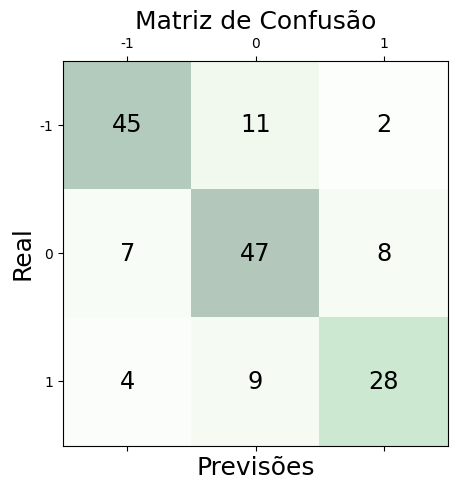

In [107]:
# Matriz de confusão

# Treinamento/teste para encontrar o melhor valor de C
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
melhor_c =2  # inserir aqui o melhor valor de C encontrado
svc = SVC(kernel='linear', C=melhor_c)
svc.fit(X_train, y_train)

# Fazer previsões e criar matriz de confusão
y_pred = svc.predict(X_test)
matriz_conf = confusion_matrix(y_test, y_pred)

# Definir as etiquetas do eixo x e y
etiquetas = ['-1', '0', '1']

# Exibir a matriz de confusão
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(matriz_conf, cmap=plt.cm.Greens, alpha=0.3)

# Configurar as etiquetas do eixo x e y
ax.set_xticklabels([''] + etiquetas)
ax.set_yticklabels([''] + etiquetas)

for i in range(matriz_conf.shape[0]):
    for j in range(matriz_conf.shape[1]):
        ax.text(x=j, y=i, s=matriz_conf[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Previsões', fontsize=18)
plt.ylabel('Real', fontsize=18)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()


In [109]:
# Definir valores de C para testar
valores_c = [0.9,1,1.5,2,3,4,5,6]

# Criar lista para armazenar os resultados
all_svm_results = []

# Loop para testar diferentes valores de C
for c in valores_c:
    # Criar o modelo SVM
    svm = SVC(kernel='linear', C=c)
    
    # Aplicar validação cruzada com k=5 e métricas f1_macro e acurácia
    scoring = ['f1_macro', 'accuracy']
    cv_results = cross_validate(svm, X, Y, cv=5, scoring=scoring)
    
    # Calcular média dos resultados para f1 e acurácia
    f1_mean = cv_results['test_f1_macro'].mean()
    accuracy_mean = cv_results['test_accuracy'].mean()

    # Adicionar resultados à lista
    all_svm_results.append([c, f1_mean, accuracy_mean])

# Exibir resultados em formato de tabela
headers = ['C', 'F1-score médio', 'Acurácia média']
print(tabulate(all_svm_results, headers=headers))


  C    F1-score médio    Acurácia média
---  ----------------  ----------------
0.9          0.628953          0.634666
1            0.632978          0.637182
1.5          0.632721          0.635932
2            0.622465          0.624713
3            0.6251            0.625947
4            0.630277          0.632166
5            0.627629          0.629658
6            0.626269          0.628416


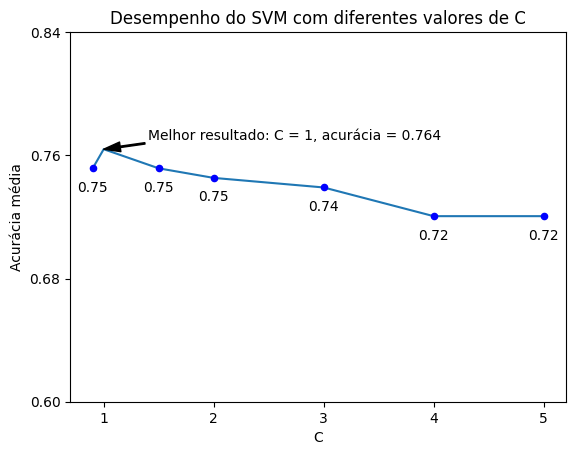

In [195]:
# Extrair valores de C e acurácia média
C_values = [result[0] for result in results]
accuracy_values = [result[2] for result in results]

# Plotar gráfico de linha
plt.plot(C_values, accuracy_values)
plt.xlabel('C')
plt.ylabel('Acurácia média')
plt.title('Desempenho do SVM com diferentes valores de C')

# Adicionar os indicadores de C na linha
best_index = accuracy_values.index(max(accuracy_values))
for i in range(len(C_values)):
    if i == best_index:
        continue
    plt.scatter(C_values[i], accuracy_values[i], color='blue', s=20,zorder=2)
    plt.text(C_values[i], accuracy_values[i]-0.008, f'{accuracy_values[i]:.2f}', horizontalalignment='center', verticalalignment='top')

# Definir os yticks personalizados
plt.yticks([i/100 for i in range(60, 91, 8)])

# Adicionar anotação com o melhor resultado
best_result = max(results, key=lambda x: x[2])
plt.annotate(f'Melhor resultado: C = {best_result[0]}, acurácia = {best_result[2]:.3f}', xy=(best_result[0], best_result[2]), 
             xytext=(best_result[0]+0.4, best_result[2]+0.006), arrowprops=dict(facecolor='black', shrink=1, lw=1, width=1, headwidth=7))

# Exibir gráfico
plt.show()

* Decision Three

In [189]:
# Importar as bibliotecas necessárias
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score



# Definir valores de max_depth para testar
valores_max_depth = [num for num in range(1, 21)]

# Criar lista para armazenar os resultados
all_dt_results = []

# Loop para testar diferentes valores de max_depth
for max_depth in valores_max_depth:
    # Criar o modelo DecisionTreeClassifier
    dt = DecisionTreeClassifier(max_depth=max_depth)
    
    # Treinar o modelo com o conjunto de treinamento
    dt.fit(X_train, y_train)
    
    # Realizar as previsões no conjunto de teste
    y_pred = dt.predict(X_test)
    
    # Calcular a acurácia do modelo
    accuracy = accuracy_score(y_test, y_pred)
    
    # Adicionar resultados à lista
    all_dt_results.append([max_depth, accuracy])

# Exibir resultados em formato de tabela
headers = ['max_depth', 'Acurácia']
print(tabulate(all_dt_results, headers=headers))

# Encontrar o melhor resultado
melhor_resultado = max(all_dt_results, key=lambda x: x[1])
print(f"Melhor resultado: max_depth={melhor_resultado[0]}, acurácia={melhor_resultado[1]}")


  max_depth    Acurácia
-----------  ----------
          1    0.47205
          2    0.559006
          3    0.590062
          4    0.596273
          5    0.608696
          6    0.627329
          7    0.608696
          8    0.608696
          9    0.627329
         10    0.627329
         11    0.627329
         12    0.621118
         13    0.608696
         14    0.614907
         15    0.63354
         16    0.645963
         17    0.639752
         18    0.639752
         19    0.614907
         20    0.63354
Melhor resultado: max_depth=16, acurácia=0.6459627329192547


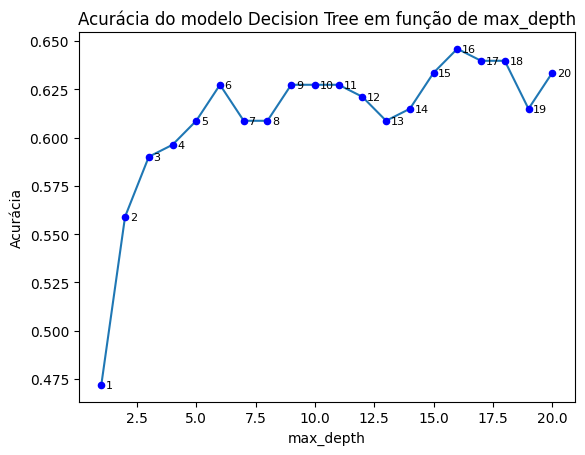

In [194]:
# Extrair os valores de max_depth e acurácia
valores_max_depth = [result[0] for result in all_dt_results]
accuracies = [result[1] for result in all_dt_results]

# Criar o gráfico
plt.plot(valores_max_depth, accuracies)
plt.xlabel('max_depth')
plt.ylabel('Acurácia')
plt.title('Acurácia do modelo Decision Tree em função de max_depth')

# Adicionar os indicadores de max_depth na linha
for i in range(len(valores_max_depth)):
    plt.scatter(valores_max_depth[i], accuracies[i], color='blue', s=20,zorder=2)
    plt.text(valores_max_depth[i]+0.2, accuracies[i]-0.002, f'{valores_max_depth[i]}', fontsize=8)

# Salvar o gráfico em um arquivo
plt.savefig('resultado_decision_tree.png')


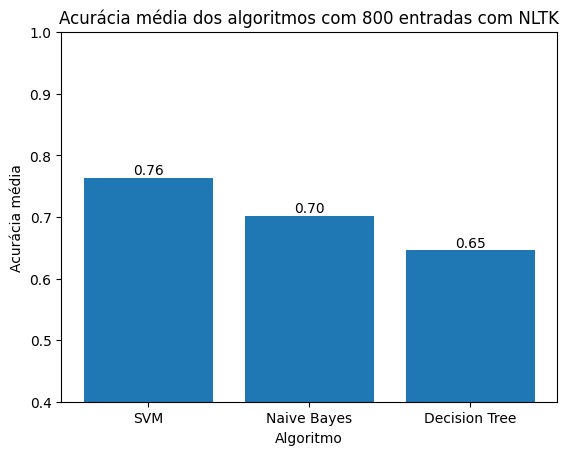

In [191]:
# SVM
svm_acc = modelo_svm.score(X_test, y_test)

# Naive Bayes
nb_acc = accuracy_score(y_testeNB, y_predNB)

# Decision Tree
dt_acc = melhor_resultado[1]

# Criar gráfico de barras
algoritmos = ['SVM', 'Naive Bayes', 'Decision Tree']
acuracias = [svm_acc, nb_acc, dt_acc]

plt.bar(algoritmos, acuracias)
plt.title('Acurácia média dos algoritmos com 800 entradas com NLTK')
plt.xlabel('Algoritmo')
plt.ylabel('Acurácia média')
plt.ylim(0.4, 1)

# Adicionar valores em cada barra
for i in range(len(acuracias)):
    plt.text(i, acuracias[i], f"{acuracias[i]:.2f}", ha='center', va='bottom')

# Exibir gráfico
plt.show()


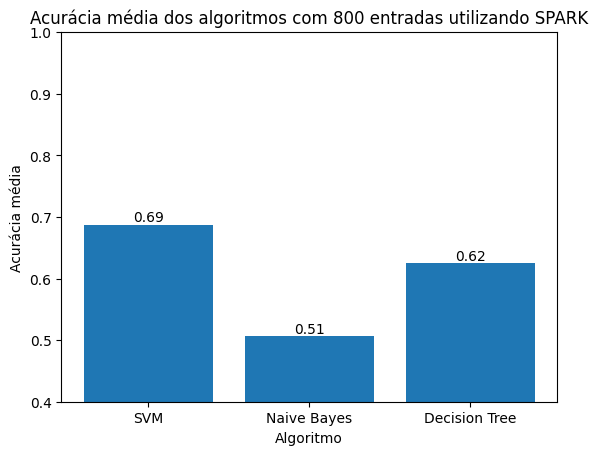

In [ ]:
# SVM
svm_acc = modelo_svm.score(X_test, y_test)

# Naive Bayes
nb_acc = accuracy_score(y_testeNB, y_predNB)

# Decision Tree
dt_acc = melhor_resultado[1]

# Criar gráfico de barras
algoritmos = ['SVM', 'Naive Bayes', 'Decision Tree']
acuracias = [svm_acc, nb_acc, dt_acc]

plt.bar(algoritmos, acuracias)
plt.title('Acurácia média dos algoritmos com 800 entradas utilizando SPARK')
plt.xlabel('Algoritmo')
plt.ylabel('Acurácia média')
plt.ylim(0.4, 1)

# Adicionar valores em cada barra
for i in range(len(acuracias)):
    plt.text(i, acuracias[i], f"{acuracias[i]:.2f}", ha='center', va='bottom')

# Exibir gráfico
plt.show()


### Clusterização

In [196]:
# Imports necessários 

import pandas as pd 
from sklearn import preprocessing
from scipy.spatial import distance_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

In [ ]:
vetorizado = TfidfVectorizer(use_idf=True)
X = vetorizado.fit_transform(tweets)
Y = rotulos

In [197]:
from sklearn import metrics

for k in range(2, 5):

 # executar o algoritmo KMeans
  kmeans = KMeans(n_clusters=k, n_init=10)
  kmeans.fit(X)
  score_mean = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
  print(k, score_mean)



2 0.006570443437558938
3 0.006201725421687391
4 0.008062014322112317


In [198]:
kmeans = KMeans(n_clusters=3,n_init=10)
kmeans.fit(X)

KMeans(n_clusters=3, n_init=10)

In [199]:
# atribuir clusters a cada exemplo
clusters = kmeans.labels_.tolist()

# criar um dicionário com os dados dos clusters
clusters_dict = { 'text': X, 'sentiment': Y, 'cluster': clusters}

# criar um DataFrame a partir do dicionário
dataframe_clusters = pd.DataFrame(clusters_dict, columns = ['text', 'sentiment', 'cluster'])

In [200]:
# agrupar os exemplos por cluster e rótulo
groups = dataframe_clusters.groupby(['cluster', 'sentiment'])

# contar o número de exemplos em cada grupo
counts = groups.size()

# imprimir o número de exemplos em cada grupo
print(counts)

cluster  sentiment
0        -1            98
          0           158
          1           135
1        -1           172
          0           109
          1            60
2        -1            30
          0            33
          1             7
dtype: int64


In [201]:
from sklearn.cluster import KMeans
import pandas as pd

# define o número de clusters
n_clusters = [2, 3]

# define as configurações para o modelo KMeans
kmeans_params = {'init': 'k-means++', 'n_init': 30, 'max_iter':1100}

# leitura dos dados
df = df_final_dataset

# criação dos clusters
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, **kmeans_params)
    kmeans.fit(X)
    
    # adiciona os rótulos dos clusters ao DataFrame
    df['cluster'] = kmeans.labels_

    # conta o número de instâncias em cada cluster e imprime os resultados
    cluster_counts = df.groupby(['cluster'])['sentiment'].value_counts()
    print('Number of clusters:', n)
    print(cluster_counts)


Number of clusters: 2
cluster  sentiment
0        -1           203
          0           161
          1            71
1         0           139
          1           131
         -1            97
Name: sentiment, dtype: int64
Number of clusters: 3
cluster  sentiment
0        -1           202
          0           156
          1            70
1         0            87
          1            82
         -1            50
2         0            57
          1            50
         -1            48
Name: sentiment, dtype: int64


## Bertimbau


In [ ]:
!pip install transformers


In [204]:
from sklearn.metrics import accuracy_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
model_name = "neuralmind/bert-large-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [ ]:

# Cria a lista para armazenar as previsões
previsoes = []

# Loop pelas instâncias do conjunto de dados
for i in range(len(tweets)):
    # Tokeniza o texto usando o tokenizer BERTimbau
    input_ids = torch.tensor(tokenizer.encode(tweets[i], add_special_tokens=True)).unsqueeze(0)
    
    # Chama o modelo BERTimbau para obter as previsões
    outputs = model(input_ids)[0]
    _, predicted = torch.max(outputs, 1)
    previsoes.append(predicted.item())

# Converte as listas em arrays NumPy
rotulos = np.array(rotulos)
previsoes = np.array(previsoes)

# Avalia as previsões
acuracia = accuracy_score(rotulos, previsoes)
print("Acurácia:", acuracia)

## Spark - nlp

In [ ]:
spark = sparknlp.start()

In [ ]:
data = pd.read_csv(diretorio+"teste803_2.csv") 

In [ ]:
# tweets = (spark.read.option("header",True) \
#                     .option("delimiter",",") \
#                     .option("multiLine", "true") \
#           .csv(diretorio+"teste803_2.csv"))

In [ ]:

nltk.download('punkt')
def clean_text(texto):

    def remove_tweet_ruido(tweets_text):
        clean_text = re.sub(r'^rt\s+', '', tweets_text) # Remove "rt " no início do texto
        clean_text = re.sub(r'@\S+', '', clean_text) # Remove menções a outros usuários
        clean_text = re.sub(r'http\S+', '', clean_text) # Remove URLs
        clean_text = clean_text.replace("\n", " ") # Substitui quebras de linha por espaços em branco
        clean_text = re.sub(r'\"', '', clean_text) # Remove aspas duplas
        clean_text = re.sub(r"['`]+", '', clean_text) # Remove aspas simples e crases

        return clean_text


    # Transforme as letras para minúscula
    texto = texto.lower()
    
    # Remova o ruido do texto
    texto = remove_tweet_ruido(texto)
    
    # Tokenize o texto em palavras
    palavras = word_tokenize(texto)
    
    # Remova pontuações
    palavras_sem_pontuacao = [palavra for palavra in palavras if palavra not in string.punctuation]

    # Junte as palavras limpas
    texto_limpo = ' '.join(palavras_sem_pontuacao)
    
    # Remova acentos
    texto_limpo = unicodedata.normalize('NFKD', texto_limpo).encode('ASCII', 'ignore').decode('ASCII')
    
    return texto_limpo


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Aplica o processamento de texto na coluna text e cria uma nova "clean_text"
data['clean_text'] = data['text'].apply(clean_text)

# Remove tweets com menos de 2 palavras e tweets que ficaram vazios
data['num_palavras'] = data['clean_text'].apply(lambda x: len(x.split()))
data = data.loc[data['num_palavras'] > 1]
data = data.dropna(axis=1, how='all')

In [ ]:
tweets = spark.createDataFrame(data)

In [ ]:
data.head(10)

,clean_text,text,sentiment,num_palavras
0,omissao do governador de brasilia e caso de ab...,@choquei Omissão do Governador de Brasília é c...,0,21
1,pcdf ja cumpriu 32 mandados judiciais contra s...,PCDF já cumpriu 32 mandados judiciais contra s...,-1,14
2,nossa apavorante as imagens do estado do stf,nossa apavorante as imagens do estado do stf,0,8
3,jk ah vou levar a capital pro meio do pais ne ...,"JK: ""Ah vou levar a capital pro meio do país n...",-1,36
4,estao agora na esplanada nao e pelas urnas e s...,@MadeiraLima5 @EPio38 Estão agora na esplanada...,1,39
5,eu acho muito bom o que esta acontecendo na es...,Eu acho muito bom o que está acontecendo na es...,1,22
6,tinha que ser com os congressistas e ministros...,@taoquei1 Tinha que ser com os Congressistas e...,1,40
7,so ressaltar que ha esquerdista infiltrados no...,@alexandre Só ressaltar que há esquerdista inf...,1,24
8,quando o stf quis prender vcs pra quem vcs ped...,"@AbrahamWeint Quando o STF quis prender vcs , ...",0,12
9,cela de prisao 22 bolsonarofujao brasilia,CELA DE PRISÃO 22\n#BolsonaroFujao \n#brasili...,-1,6


In [ ]:
document_assembler = DocumentAssembler()\
                       .setInputCol("clean_text")\
                       .setOutputCol("document")

tokenizer = Tokenizer()\
              .setInputCols(["document"])\
              .setOutputCol("token")  

# https://sparknlp.org/2022/03/07/stopwords_iso_pt_3_0.html
stop_words = StopWordsCleaner.pretrained("stopwords_iso","pt") \
.setInputCols(["token"]) \
.setOutputCol("cleanTokens")

# https://sparknlp.org/2022/03/31/lemma_gsd_pt_3_0.html
lemmatizer = LemmatizerModel.pretrained("lemma_gsd", "pt") \
              .setInputCols(["cleanTokens"]) \
              .setOutputCol("lemma")

finisher = Finisher() \
     .setInputCols(['lemma'])

pipeline = Pipeline(stages=[document_assembler, tokenizer, stop_words,lemmatizer,finisher]) 


  

stopwords_iso download started this may take some time.
Approximate size to download 2.5 KB
[OK!]
lemma_gsd download started this may take some time.
Approximate size to download 336.7 KB
[OK!]


In [ ]:
results = pipeline.fit(tweets).transform(tweets)

results = results.withColumn('finished_lemma', F.concat_ws(' ', 'finished_lemma')) \
                 .withColumn('finished_lemma', F.regexp_replace('finished_lemma', '[^a-zA-Z\\s]', ''))


In [ ]:
results.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|clean_text                                                                                                                                                                                                                                   

In [ ]:
results_df = results.toPandas()

## >> Utils <<


### Juntar todos arquivos em um só

É usado um loop for para percorrer cada arquivo individualmente. Para cada arquivo, é aberto o arquivo JSONL usando o open e readlines. Em seguida, um loop interno para percorrer cada linha do arquivo e usar a função json.loads para analisar a linha em um objeto Python.

Por fim, é usado o with open novamente para abrir um arquivo de saída chamado dados.json em modo de gravação. A função json.dump para gravar a lista dados no arquivo de saída como um objeto JSON único.


In [ ]:
arquivos = glob.glob("/content/drive/MyDrive/dataset/tweets_teste/input/*.jsonl") ## adiciona na variavel todos arquivos que terminarem com .jsonl


dados = [] ## vai armazenar todos arquivos
contador = 0

for arquivo in arquivos:
    with open(arquivo) as f:
        linhas = f.readlines()
        for linha in linhas:
            dados.append(json.loads(linha))
    contador += 1
    #if contador % 1000 == 0:
    print(f"Processando arquivo {contador}/{len(arquivos)}")

with open('/content/drive/MyDrive/dataset/tweets_teste/tweets.json', 'w') as saida:
    json.dump(dados, saida)

print("Salvamento completo!")

### Selecionar quantidade X de tweets dentro da base para reduzir o tamanho (pronto)

In [ ]:
# ler a base de dados de tweets
tweets = data

# converter a coluna de data para datetime
tweets["created_at"] = pd.to_datetime(tweets["created_at"])

# criar uma coluna com a hora de cada tweet
tweets["hora"] = tweets["created_at"].dt.hour

# selecionar aleatoriamente 1000 tweets de cada hora
tweets_selecionados = tweets.groupby("hora").apply(lambda x: x.sample(n=10, random_state=42))

# redefinir o índice do dataframe resultante
tweets_selecionados.reset_index(drop=True, inplace=True)

# salvar o resultado em um novo arquivo CSV
tweets_selecionados.head(20)
#tweets_selecionados.to_csv("tweets_selecionados.csv", index=False)


,date,tweet_text,clean_text,hora
0,2020-05-21 00:54:43+00:00,@g1maranhao Os números de mortos aumentando e ...,números mortos aumentar políticos brasil dar s...,0
1,2020-10-11 00:26:08+00:00,@gazetadopovo Lockdown no Brasil 😂😂😂😂😂 https:/...,lockdown brasil,0
2,2020-03-10 00:41:38+00:00,@rafaelbboa E o carnaval no Brasil!!! Teve loc...,carnaval brasil lockdown proibir italianos ira...,0
3,2020-05-04 00:57:07+00:00,E pensar que se o lockdown tivesse sido feito ...,pensar lockdown sido fazer desde início d essa...,0
4,2020-11-17 00:40:24+00:00,Europa: lockdown fudido\n\nBrasil: festa seman...,europa lockdown fudido brasil festa semana q vir,0
5,2020-11-04 00:52:08+00:00,Minha irmã tava resolvendo as coisas pra volta...,irmã tava resolver coisas pra voltar pro brasi...,0
6,2020-12-05 00:39:22+00:00,"2ª onda da pandemia, números crescendo, medida...",onda pandemia números crescer medidas restriti...,0
7,2021-01-28 00:48:12+00:00,Sabe quem vai derrubar @jairbolsonaro ? 🙄🙄🙄🙄🙄🙄...,saber vai derrubar nunca antes presidente frac...,0
8,2020-12-18 00:53:49+00:00,@tah_viapiana ''Eles entendem q medidas restri...,entender q medidas restritivas necessárias pq ...,0
9,2021-01-17 00:44:39+00:00,@MarioQuinet @AugustoGiacon @klaskoski @Rconst...,medidas restritivas volta pra escola vovô alfa...,0


### Formatar a coluna de data e hora para trazer somente hora e pegar N tweets


In [ ]:
from datetime import datetime

data_hora = "2023-01-08 13:59:59+00:00"
dt_obj = datetime.fromisoformat(data_hora[:-6])
hora = dt_obj.strftime("%H:%M:%S")
print(hora)

13:59:59


In [ ]:
import pandas as pd
import random
import time

random_tweets=''

# Definir a janela de tempo de uma hora
intervalo = pd.Timedelta(hours=1)

while True:
    # Carregar a base de dados de tweets em um dataframe
    tweets = pd.read_json(diretorio + 'planalto_completo.json')

    # Obter o tempo mais recente na base de dados
    ultimo_tempo = tweets['tempo'].max()

    # Selecionar apenas os tweets dentro do intervalo de uma hora
    janela_tempo = (ultimo_tempo - intervalo, ultimo_tempo)
    tweets_janela = tweets[tweets['tempo'].between(*janela_tempo)]

    # Selecionar aleatoriamente 1000 tweets da seleção
    if len(tweets_janela) > 1000:
        random_tweets += tweets_janela.sample(n=1000)
    else:
        random_tweets += tweets_janela

    # Imprimir os tweets selecionados
    for tweet in random_tweets['texto']:
        print(tweet)  # Supondo que a chave para o texto do tweet seja "texto"


### Freq de hashtags,menções e Retweets - teste (pronto)

In [ ]:
import pandas as pd
import re

In [ ]:
df = data


In [ ]:
#Extrair hashtags
def extract_hashtags(tweet):
    hashtags = re.findall(r'\#\w+', tweet)
    return hashtags
#Extrair menções
def extract_mencao(tweet):
    mencao = re.findall(r'(?<!RT )\@\w+', tweet)
    return mencao
#Extrair retweets
def extract_retweet(tweet):
    retweet = re.findall(r'RT @\w+', tweet)
    return retweet

In [ ]:
# Aplicanto as funções encima das colunas
df['hashtags'] = df['tweet_text'].apply(extract_hashtags)
df['mencao'] = df['tweet_text'].apply(extract_mencao)
df['retweet'] = df['tweet_text'].apply(extract_retweet)

# Transformando coluna de listas em linhas
hashtags_df = df.explode('hashtags')
mencao_df = df.explode('mencao')
retweet_df = df.explode('retweet')

In [ ]:
# criar os três DataFrames separadamente
freq_hashtags = pd.DataFrame(hashtags_df['hashtags'].value_counts())
freq_mencao = pd.DataFrame(mencao_df['mencao'].value_counts())
freq_retweet = pd.DataFrame(retweet_df['retweet'].value_counts())

# renomear o nome do índice (primeira coluna)
freq_hashtags = freq_hashtags.rename_axis('Hashtag').reset_index()
freq_mencao = freq_mencao.rename_axis('Mencao').reset_index()
freq_retweet = freq_retweet.rename_axis('Retweet').reset_index()

# renomear a coluna dos valores (segunda coluna)
freq_hashtags.columns = ['Hashtag', 'Quantidade']
freq_mencao.columns = ['Mencao', 'Quantidade']
freq_retweet.columns = ['Retweet', 'Quantidade']


In [ ]:
# Frequência de hashtags
freq_hashtags.head(10)

In [ ]:
# Frequência de menções
freq_mencao.head(10)

In [ ]:
# Frequência de retweets
freq_retweet.head(10)

### Stopwords

In [ ]:
stopw = pd.read_json("https://raw.githubusercontent.com/stopwords-iso/stopwords-pt/master/stopwords-pt.json")
new_stopwords = list(data[0])

In [ ]:
lang_top = data['lang'].value_counts()
lang_top = dict(lang_top)

indices = range(1, len(lang_top) + 1)

# Criando o DataFrame a partir do dicionário e da lista de índices
lang_top = pd.DataFrame(list(lang_top.items()), index=indices, columns=['lang', 'qtd'])
lang_top.head()

,lang,qtd
1,pt,40812


In [ ]:
# def clean_text(texto):
#     '''
#     Função para converter todas as letras para sua forma minúscula, selecionar apenas as letras,
#     remover stopwords e lematizar o texto. 
#     '''

#     def remove_tweet_ruido(tweets_text):

#         clean_text = re.sub(r'rt+', '', tweets_text) 
#         clean_text = re.sub(r'@\S+', '', clean_text)  
#         clean_text = re.sub(r'http\S+', '', clean_text) 
#         clean_text = clean_text.replace("\n", " ")

#         return clean_text
    
#     ### Transforme as letras para minúscula ###
#     minusculas = texto.lower()

#     texto = remove_tweet_ruido(minusculas)
    
#     ### Selecione apenas as letras do texto ##
#     letras = re.findall(r'\b[A-zÀ-úü]+\b', texto)
    
#     ### Removendo as stopwords ###
#     stops = set(new_stopwords)
#     # Retire as stopwords de letras
#     palavras_sem_stopwords = [palavra for palavra in letras if palavra not in stops]
#     # Junte as palavras sem stopwords 
#     palavras_importantes = ' '.join(palavras_sem_stopwords) 
    
#     ### Lematização ###
#     spc_letras = spc(palavras_importantes)
#     # Lematize o texto 
#     lemmas = [token.lemma_ if token.pos_ == 'VERB' else str(token) for token in spc_letras]
#     # Junte os lemmas 
#     texto_limpo = " ".join(lemmas)
    
#     ### Removendo acentos ###
#     texto_limpo = unicodedata.normalize('NFKD', texto_limpo).encode('ASCII', 'ignore').decode('ASCII')
    
#     return texto_limpo

### Melhor modelo

In [ ]:
# Import
# df_final_dataset = pd.read_excel(diretorio+"teste803.xlsx")
df_final_dataset = pd.read_csv(diretorio+"teste403.csv")
# df_final_dataset = results_df


# Primeiro teste
df_final_dataset['sentiment'].value_counts()


while accuracy <= 0.74:
  # Importe a biblioteca pandas
  import pandas as pd

  # Leia o arquivo original em um DataFrame
  df_original = df_final_dataset

  # Selecione 300 amostras aleatórias com sentiment = -1
  df_sentiment_negativo = df_original[df_original['sentiment'] == -1].sample(n=300)

  # Selecione 300 amostras aleatórias com sentiment = 0
  df_sentiment_neutro = df_original[df_original['sentiment'] == 0].sample(n=300)

  # Selecione todas as amostras com sentiment = 1
  df_sentiment_positivo = df_original[df_original['sentiment'] == 1]

  # Combine os dataframes
  df_novo = pd.concat([df_sentiment_negativo, df_sentiment_neutro, df_sentiment_positivo])

  df_final_dataset = df_novo




  # Cria as listas para armazenar os textos e rótulos
  tweets = []
  rotulos = []

  # Loop pelas instâncias do conjunto de dados
  for index, row in df_final_dataset.iterrows():
      # Adiciona o texto e rótulo das instâncias às listas correspondentes
      tweets.append(row['clean_text'])
      rotulos.append(row['sentiment'])

  df_final_dataset['sentiment'].value_counts()


  vetorizado = TfidfVectorizer(use_idf=True)
  X = vetorizado.fit_transform(tweets)
  Y = rotulos

  X_train, X_test, y_train, y_test = train_test_split(X, 
                                                      Y, 
                                                      random_state=42,
                                                      test_size=0.2
                                                    )


  #############
  # print('Número de linhas no conjunto total: {}'.format(len(tweets)))
  # print('Número de linhas no conjunto de treinamento: {} ({:.2%} do total)'.format(X_train.shape[0], X_train.shape[0]/len(tweets)))
  # print('Número de linhas no conjunto de teste: {} ({:.2%} do total)'.format(X_test.shape[0], X_test.shape[0]/len(tweets)))
  ##############

  from sklearn.model_selection import cross_val_score
  from sklearn.metrics import cohen_kappa_score

  # Define o modelo SVM
  modelo_svm = SVC(kernel='linear', C=2)
  modelo_svm.fit(X_train, y_train) # Ajusta o modelo SVM com os dados de treinamento
  resp_pred = modelo_svm.predict(X_test) # predição das classes para os dados de teste X_test

  # Aplica a validação cruzada com k=5
  scores = cross_val_score(modelo_svm, X, Y, cv=5)

  # Calcula o valor do kappa
  kappa = cohen_kappa_score(y_test, resp_pred) # calculando o coeficiente de kappa utilizando as classes verdadeiras "y_test" e as classes preditas "resp_pred"

  # Calcula a acuráciaa
  accuracy = modelo_svm.score(X_test, y_test)

  # Exibe a acurácia média, o desvio padrão, a acurácia e o valor do kappa
  print("Base de Treino com Cross Validate")
  print("Acurácia média: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


  print("\nBase de Teste")
  print("Acurácia: %0.2f " % (accuracy))
  print("Coeficiente Kappa: %0.2f" % kappa)
